<a href="https://colab.research.google.com/github/MateoPalacios512/TAM_2025_2/blob/main/NFL_Big_Data_Bowl_2026_Analysis_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

nfl_big_data_bowl_2026_prediction_path = kagglehub.competition_download('nfl-big-data-bowl-2026-prediction')

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nfl-big-data-bowl-2026-prediction/sample_submission.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/test_input.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/test.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/input_2023_w17.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/output_2023_w05.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/output_2023_w10.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/input_2023_w03.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/output_2023_w18.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/input_2023_w05.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/output_2023_w11.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/output_2023_w12.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/output_2023_w16.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/output_2023_w06.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/train/input_2023_w18.csv


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pickle
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
warnings.filterwarnings('ignore')

# ============================================================================
# GPU CONFIGURATION & OPTIMIZATION
# ============================================================================

def setup_gpu():
    """Configure GPU for optimal performance"""
    print("="*80)
    print("GPU CONFIGURATION")
    print("="*80)

    # Check available GPUs
    gpus = tf.config.list_physical_devices('GPU')
    print(f"\n🖥️  Available GPUs: {len(gpus)}")

    if gpus:
        try:
            # Enable memory growth (don't allocate all GPU memory at once)
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
                print(f"   ✓ GPU: {gpu.name} - Memory growth enabled")

            # Set GPU memory limit (optional - useful if sharing GPU)
            # tf.config.set_logical_device_configuration(
            #     gpus[0],
            #     [tf.config.LogicalDeviceConfiguration(memory_limit=4096)]  # 4GB
            # )

            # Use mixed precision for faster training
            policy = tf.keras.mixed_precision.Policy('mixed_float16')
            tf.keras.mixed_precision.set_global_policy(policy)
            print(f"   ✓ Mixed precision enabled: {policy.name}")

            logical_gpus = tf.config.list_logical_devices('GPU')
            print(f"   ✓ Logical GPUs: {len(logical_gpus)}")

        except RuntimeError as e:
            print(f"   ⚠️  GPU configuration error: {e}")
    else:
        print("   ⚠️  No GPU found - using CPU (training will be slower)")

    # Set TensorFlow options for better performance
    tf.config.optimizer.set_jit(True)  # XLA compilation
    print("   ✓ XLA (Accelerated Linear Algebra) enabled")

    print(f"\n📊 TensorFlow version: {tf.__version__}")
    print(f"📊 Keras version: {keras.__version__}")

    return len(gpus) > 0

# ============================================================================
# CONFIGURATION
# ============================================================================

CONFIG = {
    'sequence_length': 10,
    'max_frames_to_predict': 15,
    'batch_size': 256,  # Larger batch for GPU
    'epochs': 100,
    'learning_rate': 0.001,
    'validation_split': 0.15,
    'use_gpu': True,
}

# ============================================================================
# EVALUATION METRICS
# ============================================================================

def calculate_rmse(y_true, y_pred):
    """Calculate Root Mean Squared Error"""
    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)
    return rmse

def calculate_mae(y_true, y_pred):
    """Calculate Mean Absolute Error"""
    mae = np.mean(np.abs(y_true - y_pred))
    return mae

def calculate_euclidean_distance(y_true, y_pred):
    """Calculate Euclidean distance between predicted and actual positions"""
    distances = np.sqrt((y_true[:, 0] - y_pred[:, 0])**2 +
                       (y_true[:, 1] - y_pred[:, 1])**2)
    return distances

def evaluate_predictions(y_true, y_pred, split_name="Validation"):
    """Comprehensive evaluation of predictions"""
    print("\n" + "="*80)
    print(f"📊 {split_name.upper()} SET EVALUATION")
    print("="*80)

    # Overall metrics
    x_rmse = calculate_rmse(y_true[:, 0], y_pred[:, 0])
    y_rmse = calculate_rmse(y_true[:, 1], y_pred[:, 1])

    x_mae = calculate_mae(y_true[:, 0], y_pred[:, 0])
    y_mae = calculate_mae(y_true[:, 1], y_pred[:, 1])

    # Euclidean distance
    distances = calculate_euclidean_distance(y_true, y_pred)
    mean_distance = np.mean(distances)
    median_distance = np.median(distances)

    print(f"\n🎯 POSITION ACCURACY:")
    print(f"   X-coordinate:")
    print(f"      RMSE: {x_rmse:.3f} yards")
    print(f"      MAE:  {x_mae:.3f} yards")

    print(f"\n   Y-coordinate:")
    print(f"      RMSE: {y_rmse:.3f} yards")
    print(f"      MAE:  {y_mae:.3f} yards")

    print(f"\n📏 EUCLIDEAN DISTANCE:")
    print(f"   Mean:   {mean_distance:.3f} yards")
    print(f"   Median: {median_distance:.3f} yards")
    print(f"   Std:    {np.std(distances):.3f} yards")
    print(f"   Min:    {np.min(distances):.3f} yards")
    print(f"   Max:    {np.max(distances):.3f} yards")

    # Percentiles
    print(f"\n📊 DISTANCE PERCENTILES:")
    for p in [25, 50, 75, 90, 95, 99]:
        print(f"   {p}th percentile: {np.percentile(distances, p):.3f} yards")

    # Accuracy buckets
    print(f"\n🎯 ACCURACY BUCKETS:")
    for threshold in [1, 2, 5, 10, 15, 20]:
        within = (distances <= threshold).sum()
        pct = 100 * within / len(distances)
        print(f"   Within {threshold:2d} yards: {within:6,} ({pct:5.2f}%)")

    metrics = {
        'x_rmse': x_rmse,
        'y_rmse': y_rmse,
        'x_mae': x_mae,
        'y_mae': y_mae,
        'mean_distance': mean_distance,
        'median_distance': median_distance,
        'distances': distances
    }

    return metrics

def plot_predictions(y_true, y_pred, split_name="Validation", save_path="predictions_plot.png"):
    """Visualize predictions vs actual"""

    fig = plt.figure(figsize=(20, 12))

    # 1. X predictions scatter
    ax1 = plt.subplot(2, 3, 1)
    ax1.scatter(y_true[:, 0], y_pred[:, 0], alpha=0.3, s=1)
    ax1.plot([0, 120], [0, 120], 'r--', linewidth=2)
    ax1.set_xlabel('Actual X (yards)', fontsize=12)
    ax1.set_ylabel('Predicted X (yards)', fontsize=12)
    ax1.set_title(f'{split_name} - X Coordinate', fontsize=14, fontweight='bold')
    ax1.grid(alpha=0.3)

    # 2. Y predictions scatter
    ax2 = plt.subplot(2, 3, 2)
    ax2.scatter(y_true[:, 1], y_pred[:, 1], alpha=0.3, s=1)
    ax2.plot([0, 53.3], [0, 53.3], 'r--', linewidth=2)
    ax2.set_xlabel('Actual Y (yards)', fontsize=12)
    ax2.set_ylabel('Predicted Y (yards)', fontsize=12)
    ax2.set_title(f'{split_name} - Y Coordinate', fontsize=14, fontweight='bold')
    ax2.grid(alpha=0.3)

    # 3. Error distribution
    ax3 = plt.subplot(2, 3, 3)
    distances = calculate_euclidean_distance(y_true, y_pred)
    ax3.hist(distances, bins=50, alpha=0.7, edgecolor='black')
    ax3.axvline(np.mean(distances), color='red', linestyle='--',
                linewidth=2, label=f'Mean: {np.mean(distances):.2f}')
    ax3.set_xlabel('Euclidean Distance Error (yards)', fontsize=12)
    ax3.set_ylabel('Frequency', fontsize=12)
    ax3.set_title('Prediction Error Distribution', fontsize=14, fontweight='bold')
    ax3.legend()
    ax3.grid(alpha=0.3)

    # 4. X error distribution
    ax4 = plt.subplot(2, 3, 4)
    x_errors = y_true[:, 0] - y_pred[:, 0]
    ax4.hist(x_errors, bins=50, alpha=0.7, edgecolor='black', color='green')
    ax4.axvline(0, color='red', linestyle='--', linewidth=2)
    ax4.set_xlabel('X Error (yards)', fontsize=12)
    ax4.set_ylabel('Frequency', fontsize=12)
    ax4.set_title(f'X Error - Mean: {np.mean(x_errors):.3f}', fontsize=14, fontweight='bold')
    ax4.grid(alpha=0.3)

    # 5. Y error distribution
    ax5 = plt.subplot(2, 3, 5)
    y_errors = y_true[:, 1] - y_pred[:, 1]
    ax5.hist(y_errors, bins=50, alpha=0.7, edgecolor='black', color='orange')
    ax5.axvline(0, color='red', linestyle='--', linewidth=2)
    ax5.set_xlabel('Y Error (yards)', fontsize=12)
    ax5.set_ylabel('Frequency', fontsize=12)
    ax5.set_title(f'Y Error - Mean: {np.mean(y_errors):.3f}', fontsize=14, fontweight='bold')
    ax5.grid(alpha=0.3)

    # 6. Cumulative accuracy
    ax6 = plt.subplot(2, 3, 6)
    sorted_distances = np.sort(distances)
    cumulative = np.arange(1, len(sorted_distances) + 1) / len(sorted_distances) * 100
    ax6.plot(sorted_distances, cumulative, linewidth=2)
    ax6.set_xlabel('Distance Threshold (yards)', fontsize=12)
    ax6.set_ylabel('Cumulative % of Predictions', fontsize=12)
    ax6.set_title('Cumulative Accuracy Curve', fontsize=14, fontweight='bold')
    ax6.grid(alpha=0.3)

    # Add benchmarks
    for threshold in [5, 10, 15]:
        pct = (distances <= threshold).sum() / len(distances) * 100
        ax6.axvline(threshold, linestyle='--', alpha=0.5)
        ax6.text(threshold, pct, f'{pct:.1f}%', fontsize=10)

    plt.suptitle(f'{split_name} Set - Prediction Analysis',
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"\n✓ Saved plot: {save_path}")

    return fig

def plot_training_history(history, save_path="training_history.png"):
    """Plot training history"""

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Loss plot
    axes[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
    axes[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Loss (MSE)', fontsize=12)
    axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    # MAE plot
    axes[1].plot(history.history['mae'], label='Training MAE', linewidth=2)
    axes[1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2)
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('MAE (yards)', fontsize=12)
    axes[1].set_title('Training and Validation MAE', fontsize=14, fontweight='bold')
    axes[1].legend()
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"✓ Saved plot: {save_path}")

    return fig

# ============================================================================
# IMPORT FUNCTIONS FROM ORIGINAL CODE
# ============================================================================

def parse_height(height_str):
    if pd.isna(height_str):
        return np.nan
    try:
        feet, inches = map(int, str(height_str).split('-'))
        return feet * 12 + inches
    except:
        return np.nan

def calculate_age(birth_date, reference_date='2023-09-01'):
    try:
        birth = pd.to_datetime(birth_date)
        ref = pd.to_datetime(reference_date)
        return (ref - birth).days / 365.25
    except:
        return np.nan

def load_training_data(data_path='/kaggle/input/nfl-big-data-bowl-2026-prediction/train'):
    print("\n" + "="*80)
    print("LOADING TRAINING DATA")
    print("="*80)

    all_data = []
    for week in range(1, 19):
        file_path = f'{data_path}/input_2023_w{week:02d}.csv'
        try:
            df = pd.read_csv(file_path)
            all_data.append(df)
            print(f"✓ Week {week:02d}: {len(df):,} rows | {df['play_id'].nunique():,} plays")
        except FileNotFoundError:
            print(f"✗ Week {week:02d}: File not found")

    train_df = pd.concat(all_data, ignore_index=True)
    print(f"\nTotal training data: {len(train_df):,} rows")
    print(f" Unique plays: {(train_df['game_id'].astype(str) + '_' + train_df['play_id'].astype(str)).nunique():,}")
    print(f"Players to predict: {train_df['player_to_predict'].sum():,}")

    return train_df

def load_test_data():
    print("\n" + "="*80)
    print("LOADING TEST DATA")
    print("="*80)

    test_input = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2026-prediction/test_input.csv')
    test_targets = pd.read_csv('/kaggle/input/nfl-big-data-bowl-2026-prediction/test.csv')

    print(f"✓ Test input: {len(test_input):,} rows")
    print(f"✓ Test targets: {len(test_targets):,} predictions needed")

    return test_input, test_targets

def normalize_play_direction(df):
    df = df.copy()
    left_mask = df['play_direction'] == 'left'
    num_flipped = left_mask.sum()

    df.loc[left_mask, 'x'] = 120 - df.loc[left_mask, 'x']
    df.loc[left_mask, 'y'] = 53.3 - df.loc[left_mask, 'y']
    df.loc[left_mask, 'dir'] = (df.loc[left_mask, 'dir'] + 180) % 360
    df.loc[left_mask, 'o'] = (df.loc[left_mask, 'o'] + 180) % 360

    if 'ball_land_x' in df.columns:
        df.loc[left_mask, 'ball_land_x'] = 120 - df.loc[left_mask, 'ball_land_x']
        df.loc[left_mask, 'ball_land_y'] = 53.3 - df.loc[left_mask, 'ball_land_y']

    print(f"   Normalized {num_flipped:,} plays moving left → right")
    return df

def engineer_features(df):
    print("\n" + "="*80)
    print("FEATURE ENGINEERING")
    print("="*80)

    df = df.copy()

    print("✓ Computing velocity components (vx, vy)")
    df['vx'] = df['s'] * np.cos(np.radians(df['dir']))
    df['vy'] = df['s'] * np.sin(np.radians(df['dir']))

    print("✓ Computing orientation components (ox, oy)")
    df['ox'] = np.cos(np.radians(df['o']))
    df['oy'] = np.sin(np.radians(df['o']))

    if 'ball_land_x' in df.columns:
        print("✓ Computing ball landing features")
        df['dist_to_ball'] = np.sqrt(
            (df['x'] - df['ball_land_x'])**2 +
            (df['y'] - df['ball_land_y'])**2
        )
        df['angle_to_ball'] = np.arctan2(
            df['ball_land_y'] - df['y'],
            df['ball_land_x'] - df['x']
        )
        df['vel_toward_ball'] = df['s'] * np.cos(np.radians(df['dir']) - df['angle_to_ball'])
    else:
        df['dist_to_ball'] = 0
        df['angle_to_ball'] = 0
        df['vel_toward_ball'] = 0

    print("✓ Computing field position features")
    df['dist_to_left_sideline'] = df['y']
    df['dist_to_right_sideline'] = 53.3 - df['y']
    df['dist_to_nearest_sideline'] = np.minimum(df['y'], 53.3 - df['y'])
    df['dist_to_endzone'] = 120 - df['x']

    print("✓ Processing player attributes")
    df['height_inches'] = df['player_height'].apply(parse_height)
    df['height_inches'] = df['height_inches'].fillna(df['height_inches'].median())

    df['player_age'] = df['player_birth_date'].apply(calculate_age)
    df['player_age'] = df['player_age'].fillna(df['player_age'].median())

    df['bmi'] = (df['player_weight'] * 703) / (df['height_inches'] ** 2)
    df['bmi'] = df['bmi'].fillna(df['bmi'].median())

    print("✓ Creating temporal features (lags, differences)")
    df = df.sort_values(['game_id', 'play_id', 'nfl_id', 'frame_id'])

    group_cols = ['game_id', 'play_id', 'nfl_id']
    for lag in [1, 2, 3]:
        for col in ['x', 'y', 's', 'a', 'vx', 'vy']:
            df[f'{col}_lag{lag}'] = df.groupby(group_cols)[col].shift(lag)

    df['speed_change'] = df.groupby(group_cols)['s'].diff()
    df['accel_change'] = df.groupby(group_cols)['a'].diff()
    df['dir_change'] = df.groupby(group_cols)['dir'].diff()

    df.loc[df['dir_change'] > 180, 'dir_change'] -= 360
    df.loc[df['dir_change'] < -180, 'dir_change'] += 360

    print("✓ Computing rolling statistics")
    for col in ['s', 'a']:
        df[f'{col}_roll_mean'] = df.groupby(group_cols)[col].transform(
            lambda x: x.rolling(window=3, min_periods=1).mean()
        )
        df[f'{col}_roll_std'] = df.groupby(group_cols)[col].transform(
            lambda x: x.rolling(window=3, min_periods=1).std()
        )

    df = df.fillna(method='bfill').fillna(method='ffill').fillna(0)

    print(f"\n📊 Features created: {len(df.columns)} total columns")

    return df

def encode_categorical(df, encoders=None):
    df = df.copy()
    categorical_cols = ['player_position', 'player_side', 'player_role']

    if encoders is None:
        encoders = {}
        for col in categorical_cols:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
            encoders[col] = le
        return df, encoders
    else:
        for col in categorical_cols:
            if col in encoders:
                df[col] = df[col].astype(str).map(
                    lambda x: x if x in encoders[col].classes_ else encoders[col].classes_[0]
                )
                df[col] = encoders[col].transform(df[col])
        return df

def create_sequences(df, sequence_length=10, for_training=True):
    print("\n" + "="*80)
    print("CREATING SEQUENCES")
    print("="*80)

    sequence_features = [
        'x', 'y', 's', 'a', 'vx', 'vy', 'ox', 'oy', 'dir', 'o',
        'x_lag1', 'y_lag1', 's_lag1', 'a_lag1',
        'x_lag2', 'y_lag2', 's_lag2', 'a_lag2',
        'x_lag3', 'y_lag3', 's_lag3', 'a_lag3',
        'speed_change', 'accel_change', 'dir_change',
        's_roll_mean', 'a_roll_mean',
        'dist_to_left_sideline', 'dist_to_right_sideline', 'dist_to_nearest_sideline'
    ]

    static_features = [
        'player_position', 'player_side', 'player_role',
        'height_inches', 'player_weight', 'player_age', 'bmi',
        'absolute_yardline_number', 'dist_to_ball', 'angle_to_ball'
    ]

    sequences = []
    static_data = []
    targets = []
    metadata = []

    grouped = df.groupby(['game_id', 'play_id', 'nfl_id'])

    for (game_id, play_id, nfl_id), group in grouped:
        if for_training and not group['player_to_predict'].any():
            continue

        group = group.sort_values('frame_id')

        if len(group) < sequence_length:
            continue

        seq_data = group[sequence_features].iloc[-sequence_length:].values
        static = group[static_features].iloc[-1].values

        sequences.append(seq_data)
        static_data.append(static)

        if for_training and 'ball_land_x' in group.columns:
            target_x = group['ball_land_x'].iloc[-1]
            target_y = group['ball_land_y'].iloc[-1]
            targets.append([target_x, target_y])

        metadata.append({
            'game_id': game_id,
            'play_id': play_id,
            'nfl_id': nfl_id,
            'num_frames_output': group['num_frames_output'].iloc[-1] if 'num_frames_output' in group.columns else 0,
            'last_x': group['x'].iloc[-1],
            'last_y': group['y'].iloc[-1],
        })

    sequences = np.array(sequences, dtype=np.float32)
    static_data = np.array(static_data, dtype=np.float32)

    if for_training and len(targets) > 0:
        targets = np.array(targets, dtype=np.float32)
    else:
        targets = None

    print(f"✓ Created {len(sequences):,} sequences")
    print(f"✓ Sequence shape: {sequences.shape}")
    print(f"✓ Static shape: {static_data.shape}")
    if targets is not None:
        print(f"✓ Target shape: {targets.shape}")

    return sequences, static_data, targets, metadata

def build_model(sequence_shape, static_shape):
    print("\n" + "="*80)
    print("BUILDING MODEL")
    print("="*80)

    sequence_input = layers.Input(shape=sequence_shape, name='sequence_input')

    x = layers.LSTM(128, return_sequences=True)(sequence_input)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.LSTM(64, return_sequences=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    static_input = layers.Input(shape=(static_shape,), name='static_input')
    s = layers.Dense(64, activation='relu')(static_input)
    s = layers.BatchNormalization()(s)
    s = layers.Dropout(0.2)(s)
    s = layers.Dense(32, activation='relu')(s)

    combined = layers.concatenate([x, s])

    z = layers.Dense(128, activation='relu')(combined)
    z = layers.BatchNormalization()(z)
    z = layers.Dropout(0.3)(z)

    z = layers.Dense(64, activation='relu')(z)
    z = layers.Dropout(0.2)(z)

    # For mixed precision, use float32 output
    output = layers.Dense(2, dtype='float32', name='position_output')(z)

    model = keras.Model(
        inputs=[sequence_input, static_input],
        outputs=output
    )

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=CONFIG['learning_rate']),
        loss='mse',
        metrics=['mae', 'mse']
    )

    model.summary()

    return model

def train_model(model, X_seq, X_static, y, validation_split=0.15):
    print("\n" + "="*80)
    print("TRAINING MODEL")
    print("="*80)

    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True,
            verbose=1
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=7,
            min_lr=1e-6,
            verbose=1
        ),
        keras.callbacks.ModelCheckpoint(
            'best_model.keras',
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        )
    ]

    history = model.fit(
        [X_seq, X_static], y,
        batch_size=CONFIG['batch_size'],
        epochs=CONFIG['epochs'],
        validation_split=validation_split,
        callbacks=callbacks,
        verbose=1
    )

    return model, history

def create_submission(model, test_input, test_targets, metadata_lookup, scalers):
    print("\n" + "="*80)
    print("GENERATING PREDICTIONS")
    print("="*80)

    pred_dict = {}
    for meta, pred in zip(metadata_lookup, model.predict([test_input[0], test_input[1]], verbose=1)):
        key = (meta['game_id'], meta['play_id'], meta['nfl_id'])
        pred_dict[key] = {
            'x': pred[0],
            'y': pred[1],
            'last_x': meta['last_x'],
            'last_y': meta['last_y']
        }

    submissions = []
    for _, row in test_targets.iterrows():
        key = (row['game_id'], row['play_id'], row['nfl_id'])

        if key in pred_dict:
            x_pred = pred_dict[key]['x']
            y_pred = pred_dict[key]['y']
        else:
            x_pred = 60.0
            y_pred = 26.65

        submissions.append({
            'id': f"{row['game_id']}_{row['play_id']}_{row['nfl_id']}_{row['frame_id']}",
            'x': x_pred,
            'y': y_pred
        })

    submission_df = pd.DataFrame(submissions)
    submission_df.to_csv('submission.csv', index=False)

    print(f"✓ Submission created: {len(submission_df):,} predictions")
    print(f"✓ Saved to: submission.csv")

    return submission_df

# ============================================================================
# MAIN PIPELINE WITH EVALUATION
# ============================================================================

def main():
    start_time = datetime.now()

    print("\n" + "="*80)
    print(" NFL BIG DATA BOWL 2026 - ENHANCED PIPELINE WITH EVALUATION")
    print("="*80)

    # Setup GPU
    has_gpu = setup_gpu()

    # Load data
    train_df = load_training_data()
    test_input_df, test_targets_df = load_test_data()

    # Preprocess
    print("\n📍 Step 1: Normalizing play direction...")
    train_df = normalize_play_direction(train_df)
    test_input_df = normalize_play_direction(test_input_df)

    # Feature engineering
    print("\n📍 Step 2: Feature engineering...")
    train_df = engineer_features(train_df)
    test_input_df = engineer_features(test_input_df)

    # Encode categorical
    print("\n📍 Step 3: Encoding categorical variables...")
    train_df, encoders = encode_categorical(train_df)
    test_input_df = encode_categorical(test_input_df, encoders)

    # Create sequences
    print("\n📍 Step 4: Creating sequences...")
    X_seq_all, X_static_all, y_all, metadata_all = create_sequences(
        train_df, CONFIG['sequence_length'], for_training=True
    )

    X_seq_test, X_static_test, _, metadata_test = create_sequences(
        test_input_df, CONFIG['sequence_length'], for_training=False
    )

    # Split train/validation
    print("\n📍 Step 5: Splitting train/validation...")
    n_samples = len(X_seq_all)
    n_val = int(n_samples * CONFIG['validation_split'])

    # Random shuffle
    indices = np.random.permutation(n_samples)
    train_idx = indices[n_val:]
    val_idx = indices[:n_val]

    X_seq_train = X_seq_all[train_idx]
    X_static_train = X_static_all[train_idx]
    y_train = y_all[train_idx]

    X_seq_val = X_seq_all[val_idx]
    X_static_val = X_static_all[val_idx]
    y_val = y_all[val_idx]

    print(f"   Training samples: {len(X_seq_train):,}")
    print(f"   Validation samples: {len(X_seq_val):,}")

    # Scale features
    print("\n📍 Step 6: Scaling features...")
    scaler_seq = StandardScaler()
    scaler_static = StandardScaler()

    # Scale sequence features
    X_seq_train_flat = X_seq_train.reshape(-1, X_seq_train.shape[-1])
    X_seq_train_scaled = scaler_seq.fit_transform(X_seq_train_flat).reshape(X_seq_train.shape)

    X_seq_val_flat = X_seq_val.reshape(-1, X_seq_val.shape[-1])
    X_seq_val_scaled = scaler_seq.transform(X_seq_val_flat).reshape(X_seq_val.shape)

    # Scale static features
    X_static_train_scaled = scaler_static.fit_transform(X_static_train)
    X_static_val_scaled = scaler_static.transform(X_static_val)

    # Scale test features
    X_seq_test_flat = X_seq_test.reshape(-1, X_seq_test.shape[-1])
    X_seq_test_scaled = scaler_seq.transform(X_seq_test_flat).reshape(X_seq_test.shape)
    X_static_test_scaled = scaler_static.transform(X_static_test)

    # Build model
    print("\n📍 Step 7: Building model...")
    model = build_model(
        sequence_shape=(X_seq_train.shape[1], X_seq_train.shape[2]),
        static_shape=X_static_train.shape[1]
    )

    # Train model WITHOUT validation_split (we already split)
    print("\n📍 Step 8: Training model...")

    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=15,
            restore_best_weights=True,
            verbose=1
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=7,
            min_lr=1e-6,
            verbose=1
        ),
        keras.callbacks.ModelCheckpoint(
            'best_model.keras',
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        )
    ]

    history = model.fit(
        [X_seq_train_scaled, X_static_train_scaled], y_train,
        validation_data=([X_seq_val_scaled, X_static_val_scaled], y_val),
        batch_size=CONFIG['batch_size'],
        epochs=CONFIG['epochs'],
        callbacks=callbacks,
        verbose=1
    )

    # Plot training history
    print("\n📍 Step 9: Plotting training history...")
    plot_training_history(history, "training_history.png")

    # Evaluate on training set
    print("\n📍 Step 10: Evaluating on training set...")
    y_train_pred = model.predict([X_seq_train_scaled, X_static_train_scaled], verbose=0)
    train_metrics = evaluate_predictions(y_train, y_train_pred, "Training")
    plot_predictions(y_train, y_train_pred, "Training", "predictions_train.png")

    # Evaluate on validation set
    print("\n📍 Step 11: Evaluating on validation set...")
    y_val_pred = model.predict([X_seq_val_scaled, X_static_val_scaled], verbose=0)
    val_metrics = evaluate_predictions(y_val, y_val_pred, "Validation")
    plot_predictions(y_val, y_val_pred, "Validation", "predictions_val.png")

    # Save model and artifacts
    print("\n📍 Step 12: Saving model and artifacts...")
    model.save('nfl_model_final.keras')
    with open('scalers.pkl', 'wb') as f:
        pickle.dump({'seq': scaler_seq, 'static': scaler_static, 'encoders': encoders}, f)

    # Save metrics to file
    metrics_summary = {
        'training': {
            'x_rmse': float(train_metrics['x_rmse']),
            'y_rmse': float(train_metrics['y_rmse']),
            'x_mae': float(train_metrics['x_mae']),
            'y_mae': float(train_metrics['y_mae']),
            'mean_distance': float(train_metrics['mean_distance']),
            'median_distance': float(train_metrics['median_distance'])
        },
        'validation': {
            'x_rmse': float(val_metrics['x_rmse']),
            'y_rmse': float(val_metrics['y_rmse']),
            'x_mae': float(val_metrics['x_mae']),
            'y_mae': float(val_metrics['y_mae']),
            'mean_distance': float(val_metrics['mean_distance']),
            'median_distance': float(val_metrics['median_distance'])
        }
    }

    with open('metrics.pkl', 'wb') as f:
        pickle.dump(metrics_summary, f)

    # Create submission
    print("\n📍 Step 13: Creating submission...")
    submission = create_submission(
        model,
        (X_seq_test_scaled, X_static_test_scaled),
        test_targets_df,
        metadata_test,
        {'seq': scaler_seq, 'static': scaler_static}
    )

    # Final summary
    end_time = datetime.now()
    duration = end_time - start_time

    print("\n" + "="*80)
    print("✅ PIPELINE COMPLETE!")
    print("="*80)

    print(f"\n⏱️  Total Time: {duration}")

    print(f"\n📁 Files created:")
    print(f"   • nfl_model_final.keras - Trained model")
    print(f"   • best_model.keras - Best model checkpoint")
    print(f"   • scalers.pkl - Feature scalers and encoders")
    print(f"   • metrics.pkl - Evaluation metrics")
    print(f"   • submission.csv - Final predictions ({len(submission):,} rows)")
    print(f"   • training_history.png - Training curves")
    print(f"   • predictions_train.png - Training set predictions")
    print(f"   • predictions_val.png - Validation set predictions")

    print(f"\n📊 FINAL RESULTS:")
    print(f"\n   Training Set:")
    print(f"      RMSE (X): {train_metrics['x_rmse']:.3f} yards")
    print(f"      RMSE (Y): {train_metrics['y_rmse']:.3f} yards")
    print(f"      Mean Distance Error: {train_metrics['mean_distance']:.3f} yards")

    print(f"\n   Validation Set:")
    print(f"      RMSE (X): {val_metrics['x_rmse']:.3f} yards")
    print(f"      RMSE (Y): {val_metrics['y_rmse']:.3f} yards")
    print(f"      Mean Distance Error: {val_metrics['mean_distance']:.3f} yards")

    print(f"\n🎯 Model Performance Summary:")
    within_5_val = (val_metrics['distances'] <= 5).sum() / len(val_metrics['distances']) * 100
    within_10_val = (val_metrics['distances'] <= 10).sum() / len(val_metrics['distances']) * 100
    print(f"   Predictions within 5 yards: {within_5_val:.1f}%")
    print(f"   Predictions within 10 yards: {within_10_val:.1f}%")

    print("\n" + "="*80)

    return model, history, submission, train_metrics, val_metrics

# ============================================================================
# RUN
# ============================================================================

if __name__ == "__main__":
    model, history, submission, train_metrics, val_metrics = main()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pickle
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
warnings.filterwarnings('ignore')

def load_training_data(data_path='/kaggle/input/nfl-big-data-bowl-2026-prediction/train'):
    print("\n" + "="*80)
    print("LOADING TRAINING DATA")
    print("="*80)

    all_data = []
    for week in range(1, 19):
        file_path = f'{data_path}/input_2023_w{week:02d}.csv'
        try:
            df = pd.read_csv(file_path)
            all_data.append(df)
            print(f"✓ Week {week:02d}: {len(df):,} rows | {df['play_id'].nunique():,} plays")
        except FileNotFoundError:
            print(f"✗ Week {week:02d}: File not found")

    train_df = pd.concat(all_data, ignore_index=True)
    print(f"\nTotal training data: {len(train_df):,} rows")
    print(f" Unique plays: {(train_df['game_id'].astype(str) + '_' + train_df['play_id'].astype(str)).nunique():,}")
    print(f"Players to predict: {train_df['player_to_predict'].sum():,}")

    return train_df

train_df=load_training_data()


LOADING TRAINING DATA
✓ Week 01: 285,714 rows | 748 plays
✓ Week 02: 288,586 rows | 777 plays
✓ Week 03: 297,757 rows | 823 plays
✓ Week 04: 272,475 rows | 710 plays
✓ Week 05: 254,779 rows | 677 plays
✓ Week 06: 270,676 rows | 715 plays
✓ Week 07: 233,597 rows | 646 plays
✓ Week 08: 281,011 rows | 765 plays
✓ Week 09: 252,796 rows | 656 plays
✓ Week 10: 260,372 rows | 673 plays
✓ Week 11: 243,413 rows | 657 plays
✓ Week 12: 294,940 rows | 755 plays
✓ Week 13: 233,755 rows | 622 plays
✓ Week 14: 279,972 rows | 738 plays
✓ Week 15: 281,820 rows | 702 plays
✓ Week 16: 316,417 rows | 822 plays
✓ Week 17: 277,582 rows | 734 plays
✓ Week 18: 254,917 rows | 686 plays

Total training data: 4,880,579 rows
 Unique plays: 14,108
Players to predict: 1,303,440


In [ ]:
train_df.head()

,game_id,play_id,player_to_predict,nfl_id,frame_id,play_direction,absolute_yardline_number,player_name,player_height,player_weight,...,player_role,x,y,s,a,dir,o,num_frames_output,ball_land_x,ball_land_y
0,2023090700,101,False,54527,1,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.33,36.94,0.09,0.39,322.40,238.24,21,63.259998,-0.22
1,2023090700,101,False,54527,2,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.33,36.94,0.04,0.61,200.89,236.05,21,63.259998,-0.22
2,2023090700,101,False,54527,3,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.33,36.93,0.12,0.73,147.55,240.60,21,63.259998,-0.22
3,2023090700,101,False,54527,4,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.35,36.92,0.23,0.81,131.40,244.25,21,63.259998,-0.22
4,2023090700,101,False,54527,5,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.37,36.90,0.35,0.82,123.26,244.25,21,63.259998,-0.22


In [ ]:
train_df.describe()

,game_id,play_id,nfl_id,frame_id,absolute_yardline_number,player_weight,x,y,s,a,dir,o,num_frames_output,ball_land_x,ball_land_y
count,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06
mean,2.023155e+09,2.196409e+03,4.955890e+04,1.613179e+01,6.055045e+01,2.112783e+02,6.050074e+01,2.681190e+01,3.019878e+00,2.118335e+00,1.804972e+02,1.815366e+02,1.164147e+01,6.051581e+01,2.663766e+01
std,2.011405e+05,1.246426e+03,5.210338e+03,1.113008e+01,2.305935e+01,2.217747e+01,2.348919e+01,1.000620e+01,2.227939e+00,1.415794e+00,1.007162e+02,9.800912e+01,5.331537e+00,2.529643e+01,1.543814e+01
min,2.023091e+09,5.400000e+01,3.084200e+04,1.000000e+00,1.100000e+01,1.530000e+02,4.100000e-01,6.200000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00,-5.260000e+00,-3.910000e+00
25%,2.023101e+09,1.150000e+03,4.519800e+04,8.000000e+00,4.100000e+01,1.950000e+02,4.263000e+01,1.899000e+01,1.090000e+00,1.010000e+00,9.091000e+01,9.174000e+01,8.000000e+00,4.261000e+01,1.330000e+01
50%,2.023111e+09,2.171000e+03,5.241300e+04,1.500000e+01,6.100000e+01,2.070000e+02,6.041000e+01,2.685000e+01,2.720000e+00,1.920000e+00,1.795600e+02,1.801400e+02,1.000000e+01,6.051000e+01,2.647000e+01
75%,2.023121e+09,3.246000e+03,5.450000e+04,2.200000e+01,8.000000e+01,2.250000e+02,7.823000e+01,3.462000e+01,4.620000e+00,3.040000e+00,2.708300e+02,2.715800e+02,1.400000e+01,7.847000e+01,3.987000e+01
max,2.024011e+09,5.258000e+03,5.667300e+04,1.230000e+02,1.090000e+02,3.580000e+02,1.198600e+02,5.288000e+01,1.253000e+01,1.712000e+01,3.600000e+02,3.600000e+02,9.400000e+01,1.258500e+02,5.733000e+01


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4880579 entries, 0 to 4880578
Data columns (total 23 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   game_id                   int64  
 1   play_id                   int64  
 2   player_to_predict         bool   
 3   nfl_id                    int64  
 4   frame_id                  int64  
 5   play_direction            object 
 6   absolute_yardline_number  int64  
 7   player_name               object 
 8   player_height             object 
 9   player_weight             int64  
 10  player_birth_date         object 
 11  player_position           object 
 12  player_side               object 
 13  player_role               object 
 14  x                         float64
 15  y                         float64
 16  s                         float64
 17  a                         float64
 18  dir                       float64
 19  o                         float64
 20  num_frames_output       

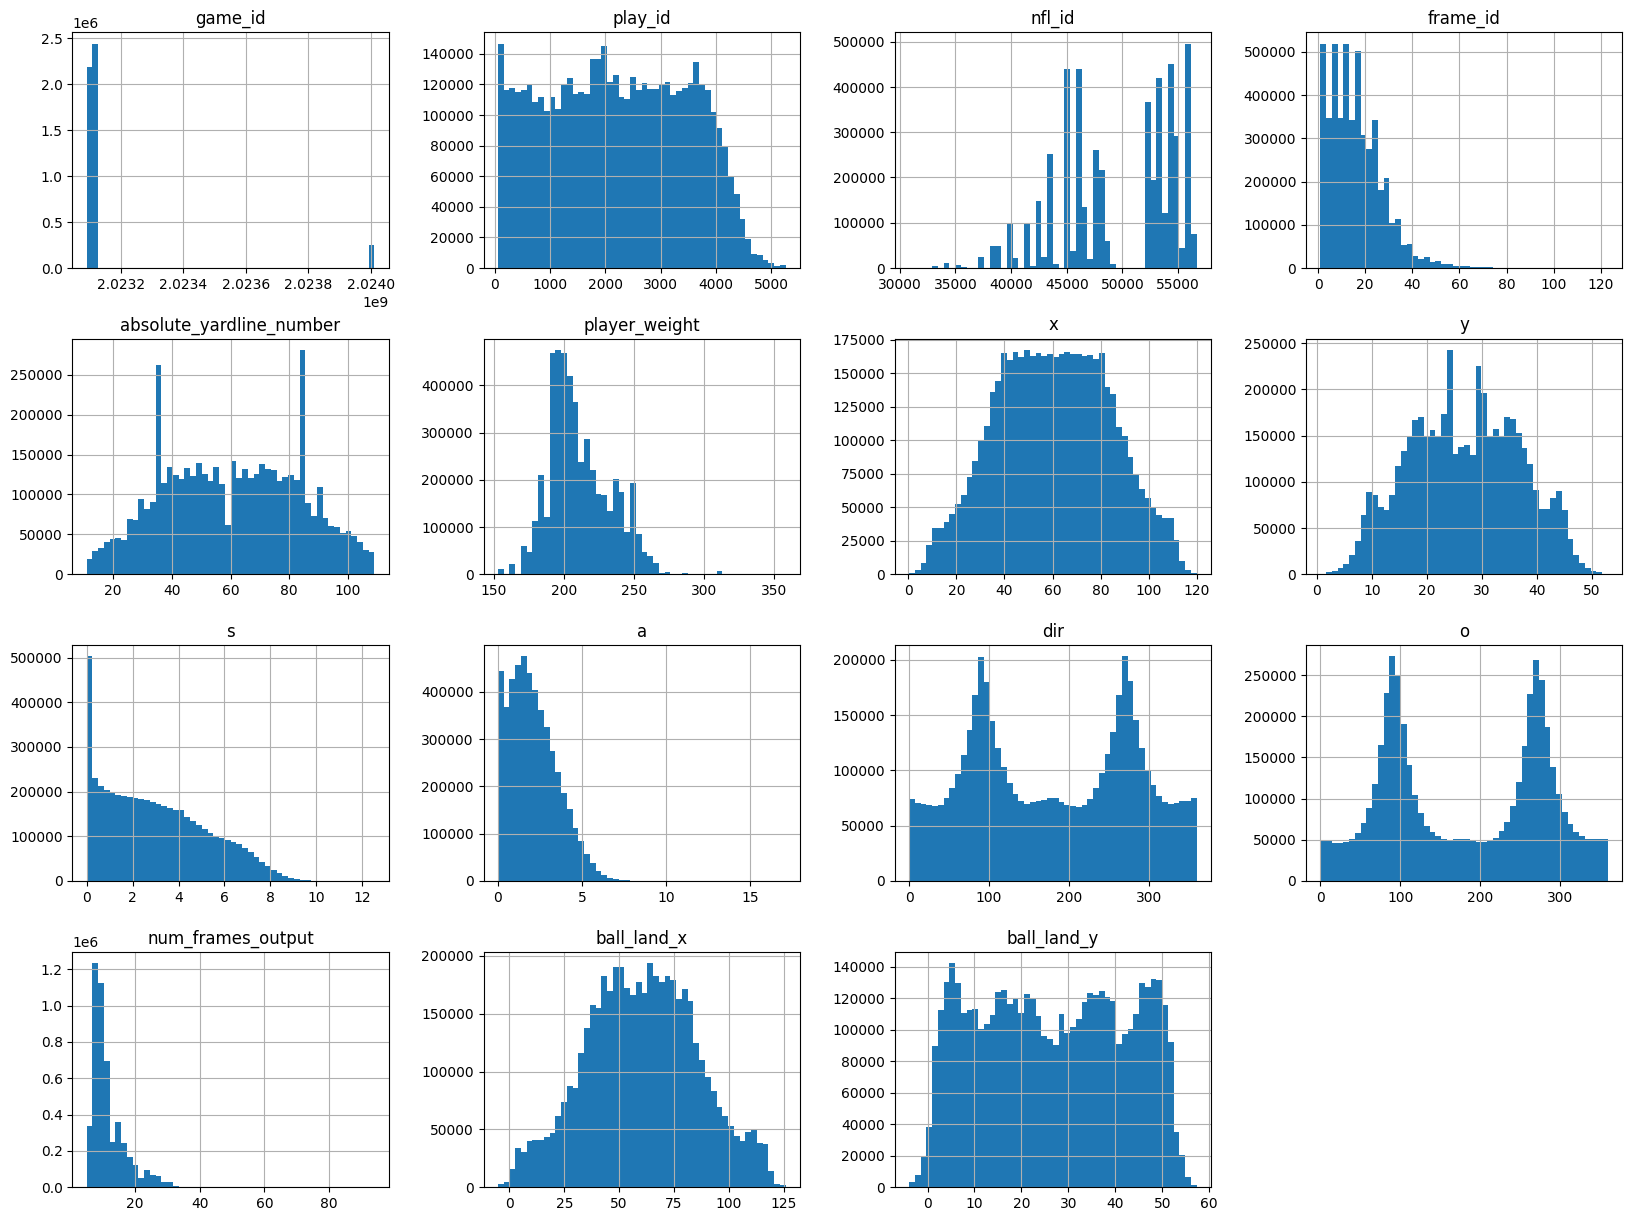

In [ ]:
train_df.hist(bins=50, figsize=(20,15))
plt.show()

In [ ]:

corr_matrix = train_df.corr() #función para calcular las correlaciones entre las variables
corr_matrix.style.background_gradient(cmap='coolwarm')

NameError: name 'housing' is not defined